# Time-Series Modeling

This lesson is adapted from Sean Abu: 

http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

With examples from Forecasting Principles and Practice, by Hyndman and Athanastopoulos: 

https://www.otexts.org/fpp

The latter is an excellent text book and worth checking out.  I also recommend their fpp package for R, which provides some nice functionality to auto-select the order of an ARIMA model.  

### Basics

A time-series is a series of data points indexed in time order.  It is naturally one-dimensional, and for our purposes we will consider that all points are equally spaced.

We may want to model time series for either inference (understanding statistical relationships), or for forecasting.  We may select different approaches depending on our interest.  There are two main approaches we will consider here: 

1. Regression on time-series data. This is about predicting a time series based on exogenous variables.  
2. ARIMA modeling.  This is about predicting a time series as a function of its past values.  

We can also combine the two: ARIMA models with exogenous regressors.  

The focus today is on the modeling.  Pandas provides some nice data wrangling methods for working with time series data which are documented here: 

http://pandas.pydata.org/pandas-docs/stable/timeseries.html


### Regression on time-series data


In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
# This data has
air = pd.read_csv('data/ausair.csv', parse_dates=['YEAR'], index_col='YEAR')
air

,AUSAIR,GUINEARICE
YEAR,,
1970-01-01,7.318700,0.311405
1971-01-01,7.326600,0.325180
1972-01-01,7.795600,0.339565
1973-01-01,9.384600,0.354580
1974-01-01,10.664700,0.370265
1975-01-01,11.055100,0.386640
1976-01-01,10.864300,0.403740
1977-01-01,11.306500,0.421600
1978-01-01,12.122300,0.440250


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0CC3E9F0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0CC8D6F0>], dtype=object)

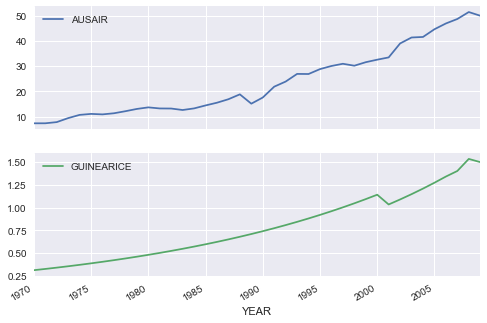

In [3]:
# Both time series are growing over the period of interest...

air.plot(subplots=True)

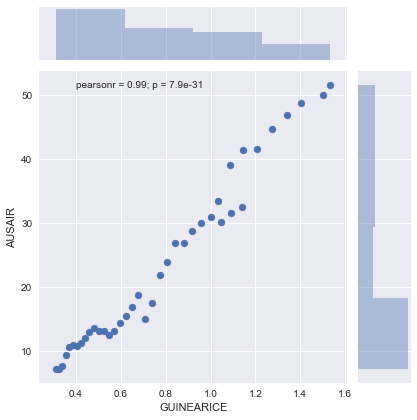

In [4]:
# when we plot them against each other, they look to be highly correlated...

sns.jointplot(x="GUINEARICE", y="AUSAIR", data=air)

In [5]:
# so let's estimate a regression model

mod = smf.ols(formula='AUSAIR ~ GUINEARICE', data=air)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AUSAIR   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1272.
Date:                Mon, 10 Apr 2017   Prob (F-statistic):           7.94e-31
Time:                        17:10:54   Log-Likelihood:                -89.643
No. Observations:                  40   AIC:                             183.3
Df Residuals:                      38   BIC:                             186.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7297      0.903     -6.348      0.0

#### Woohoo!  We got an r-squared of 0.97.  This is a great model!  Right?

Sorry to disappoint, but this is an example of **spurious regression**.  Spurious regression can happen when working with time series that are non-stationary.  

Stationary: Model does not depwends on the time series in which it's observed.

I would add that the model lacks a theoretical basis as well.  It clearly falls in the category of "If you can't explain it, you can't use it!"  However, spurious regression can occur even when there is a theoretical basis for the model.  

A stationary time series is one whose properties do not depend on the time at which the series is observed.  To avoid spurious regression, we want the dependent variable and all regressors to be stationary.  

One way to tell if data are stationary is to plot them, and look for either a trend or a cycle


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0D475C50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0D56F7D0>], dtype=object)

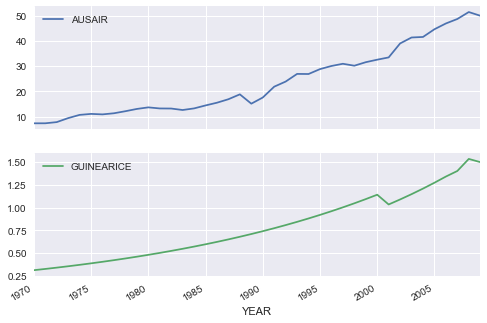

In [6]:
# check for trend or cycle

air.plot(subplots=True)

We can also look at plots of the auto-correlation function (ACF).  auto-correlation is the correlation of the time-series past values.  There are some statistical tests for this as well, but often a graphical analysis is good enough. 

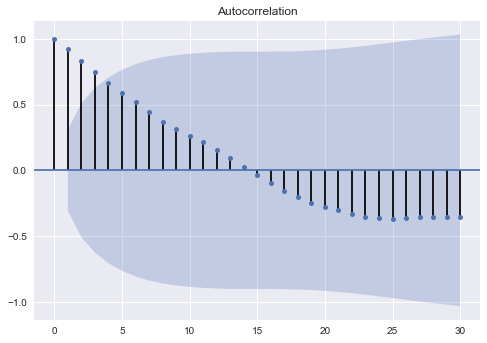

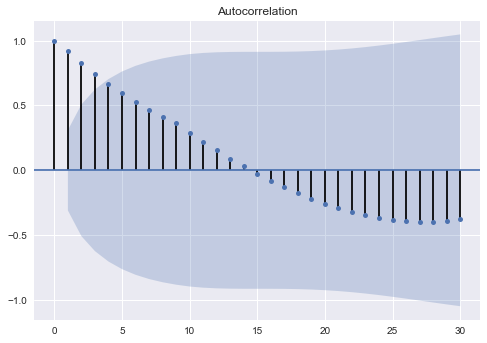

In [7]:
# ACF plots

fig = sm.graphics.tsa.plot_acf(air['AUSAIR'], lags=30)
fig = sm.graphics.tsa.plot_acf(air['GUINEARICE'], lags=30)

What do we do if the data are not stationary?  There are a few strategies, but differencing usually works.  All this means is subtracting each value from the previous value.  That way, you are modeling the change, rather than the total value.  

In [8]:
# shift moves things by the specified number of rows

air['AUSAIR_DIFF'] = air['AUSAIR'] - air['AUSAIR'].shift(1)  
air['GUINEARICE_DIFF'] = air['GUINEARICE'] - air['GUINEARICE'].shift(1)  
air.head()

,AUSAIR,GUINEARICE,AUSAIR_DIFF,GUINEARICE_DIFF
YEAR,,,,
1970-01-01,7.3187,0.311405,NaN,NaN
1971-01-01,7.3266,0.325180,0.0079,0.013775
1972-01-01,7.7956,0.339565,0.4690,0.014385
1973-01-01,9.3846,0.354580,1.5890,0.015015
1974-01-01,10.6647,0.370265,1.2801,0.015685


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0D636A10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0D7D12B0>], dtype=object)

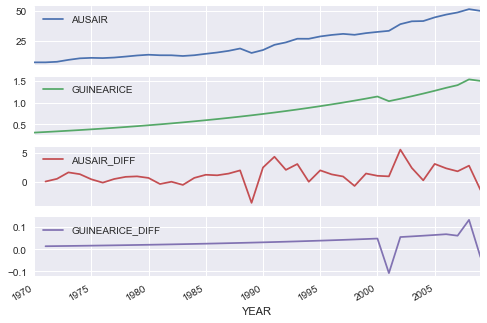

In [9]:
# now does it look stationary? 

air.plot(subplots=True)

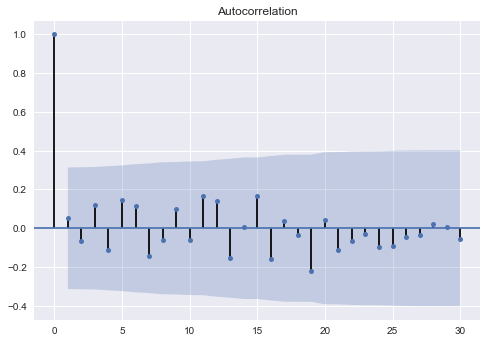

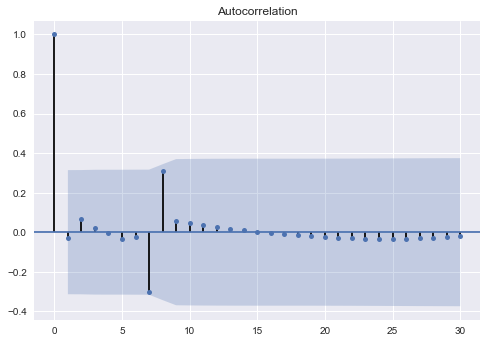

In [10]:
# ACF plots
# the first row is missing, so skip that one..

fig = sm.graphics.tsa.plot_acf(air['AUSAIR_DIFF'][1:], lags=30)
fig = sm.graphics.tsa.plot_acf(air['GUINEARICE_DIFF'][1:], lags=30)

In [11]:
# if we have to, we can also calculate a second difference
# don't go beyond 2

air['AUSAIR_2DIFF'] = air['AUSAIR_DIFF'] - air['AUSAIR_DIFF'].shift(1)  
air['GUINEARICE_2DIFF'] = air['GUINEARICE_DIFF'] - air['GUINEARICE_DIFF'].shift(1)  
air.head()


,AUSAIR,GUINEARICE,AUSAIR_DIFF,GUINEARICE_DIFF,AUSAIR_2DIFF,GUINEARICE_2DIFF
YEAR,,,,,,
1970-01-01,7.3187,0.311405,NaN,NaN,NaN,NaN
1971-01-01,7.3266,0.325180,0.0079,0.013775,NaN,NaN
1972-01-01,7.7956,0.339565,0.4690,0.014385,0.4611,0.00061
1973-01-01,9.3846,0.354580,1.5890,0.015015,1.1200,0.00063
1974-01-01,10.6647,0.370265,1.2801,0.015685,-0.3089,0.00067


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0DAD2BB0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0DAB2730>], dtype=object)

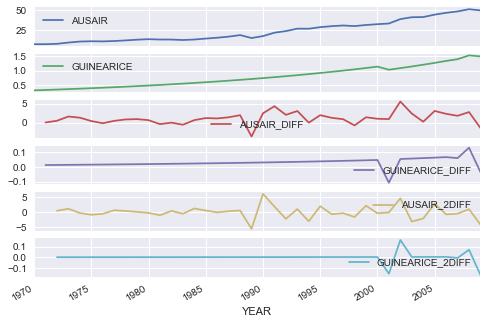

In [12]:

air.plot(subplots=True)

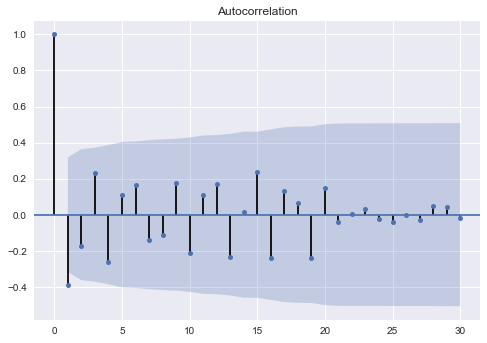

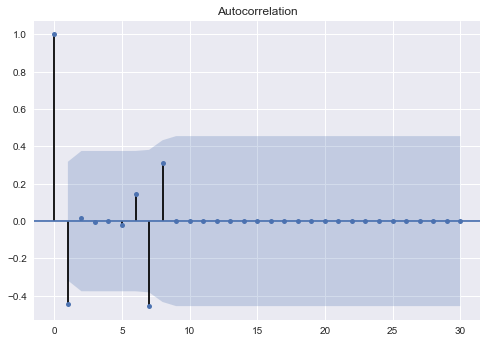

In [13]:
# ACF plots
# the first two rows are missing, so skip those..
#This is a difference of the difference

fig = sm.graphics.tsa.plot_acf(air['AUSAIR_2DIFF'][2:], lags=30)
fig = sm.graphics.tsa.plot_acf(air['GUINEARICE_2DIFF'][2:], lags=30)

In [14]:
# now what if we estimate the same model on the differenced data

mod = smf.ols(formula='AUSAIR_DIFF ~ GUINEARICE_DIFF', data=air)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            AUSAIR_DIFF   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     5.295
Date:                Mon, 10 Apr 2017   Prob (F-statistic):             0.0271
Time:                        17:11:38   Log-Likelihood:                -70.079
No. Observations:                  39   AIC:                             144.2
Df Residuals:                      37   BIC:                             147.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5881      0.326     

In [15]:
# now what if we estimate the same model on the second differenced data

mod = smf.ols(formula='AUSAIR_2DIFF ~ GUINEARICE_2DIFF', data=air)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           AUSAIR_2DIFF   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     7.088
Date:                Mon, 10 Apr 2017   Prob (F-statistic):             0.0115
Time:                        17:11:39   Log-Likelihood:                -79.187
No. Observations:                  38   AIC:                             162.4
Df Residuals:                      36   BIC:                             165.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0150      0.324  

## Homework

The data folder contains a time-series data set of ridership on the BART rail system from 2001 through 2015.  Estimate a regression model of the ridership (RIDERS) as a function of variables included in the data set.  Build as complete of a model as you can, but be sure you can explain it!

In [55]:
BART = pd.read_csv('data/BARTEstimationFile.csv')
BART

,RIDERS,MONTH,STATIONS,CASH_FARE_2010USD_BART,AVG_FARE_2010USD_BART,HH,HH_0VEH,POP,WORKERS,MEDIAN_HHINC_2010USD,...,EDHEALTH_EMP,LEISURE_EMP,OTHER_EMP,FUEL_PRICE_2010USD,FUEL_COST_2010USD,TOLL_BB_PK_2010USD,TOLL_BB_OP_2010USD,TOLL_BB_CARPOOL_2010USD,CASUAL_CARPOOL,BART_STRIKE
0,321180.5238,1/1/2001,39,3.262745,2.555435,1452556.571,187359.1429,3870692.571,1924489.571,85841.07733,...,314779.0,179565.0,1317382.0,2.240335,0.101833,2.490645,2.490645,0.000000,1,0
1,334885.1053,2/1/2001,39,3.249754,2.545259,1452696.413,187278.4921,3870052.746,1923471.413,85401.59874,...,319473.0,181972.0,1321821.0,2.227694,0.101182,2.480728,2.480728,0.000000,1,0
2,340021.5455,3/1/2001,39,3.242376,2.539481,1452836.254,187197.8413,3869412.921,1922453.254,85110.28356,...,321266.0,184828.0,1331919.0,2.290702,0.103965,2.475096,2.475096,0.000000,1,0
3,333794.4286,4/1/2001,39,3.229546,2.529432,1452976.095,187117.1905,3868773.095,1921435.095,84676.45762,...,321919.0,185372.0,1308563.0,2.436951,0.110519,2.465302,2.465302,0.000000,1,0
4,333847.4545,5/1/2001,39,3.215007,2.518045,1453115.937,187036.5397,3868133.270,1920416.937,84198.65633,...,323980.0,188738.0,1302376.0,2.532738,0.114777,2.454204,2.454204,0.000000,1,0
5,329447.8095,6/1/2001,39,3.209588,2.513801,1453255.778,186955.8889,3867493.444,1919398.778,83960.33478,...,326345.0,190404.0,1306233.0,2.524794,0.114330,2.450067,2.450067,0.000000,1,0
6,324565.6000,7/1/2001,39,3.218629,2.443754,1453395.619,186875.2381,3866853.619,1918380.619,84100.17146,...,294427.0,190728.0,1285061.0,2.369747,0.107228,2.456969,2.456969,0.000000,1,0
7,321757.9130,8/1/2001,39,3.218629,2.443754,1453535.460,186794.5873,3866213.794,1917362.460,84003.51416,...,289318.0,191763.0,1279206.0,2.137563,0.096759,2.456969,2.456969,0.000000,1,0
8,321320.8421,9/1/2001,39,3.204188,2.432790,1453675.302,186713.9365,3865573.968,1916344.302,83530.39581,...,319470.0,188124.0,1269755.0,2.291850,0.103782,2.445945,2.445945,0.000000,1,0
9,315571.1818,10/1/2001,39,3.215007,2.441004,1453815.143,186633.2857,3864934.143,1915326.143,83715.91371,...,327365.0,183662.0,1252495.0,2.187923,0.099113,2.454204,2.454204,0.000000,1,0


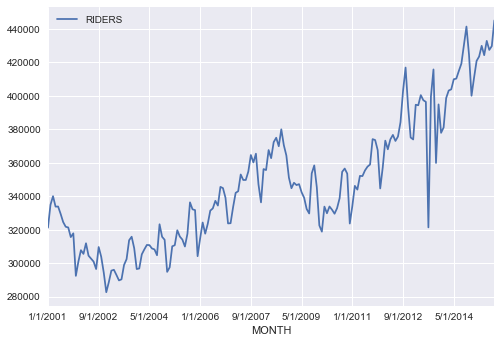

In [56]:
BART.plot(x='MONTH',y='RIDERS')

In [57]:
BART.plot(x='MONTH',y='RIDERS_DIFF')

KeyError: 'RIDERS_DIFF'

In [58]:
BART.plot(x='MONTH',y='RIDERS_DIFF_DIFF')

KeyError: 'RIDERS_DIFF_DIFF'

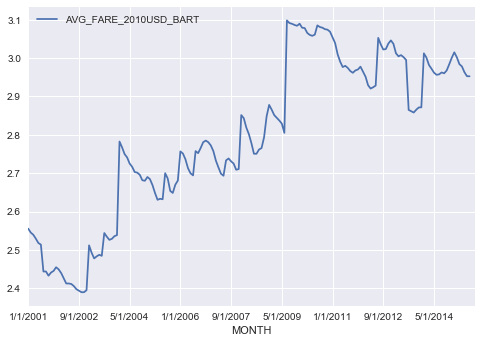

In [59]:
BART.plot(x='MONTH',y='AVG_FARE_2010USD_BART')

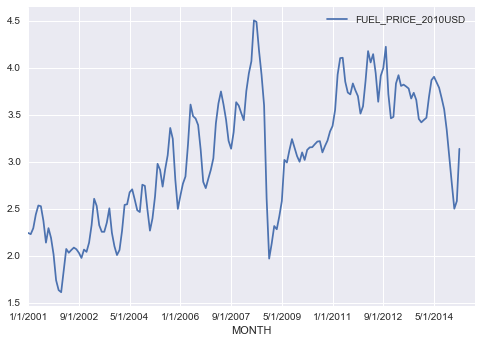

In [60]:
BART.plot(x='MONTH',y='FUEL_PRICE_2010USD')

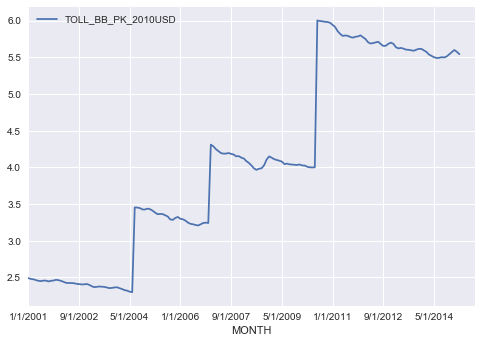

In [61]:
BART.plot(x='MONTH',y='TOLL_BB_PK_2010USD')

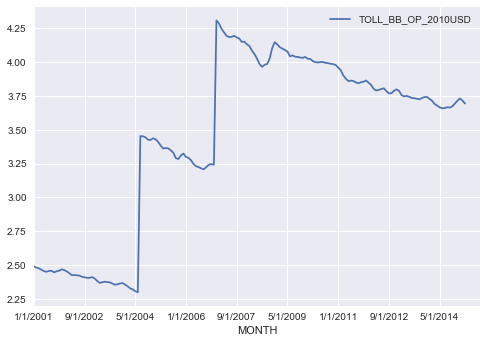

In [62]:
BART.plot(x='MONTH',y='TOLL_BB_OP_2010USD')

In [63]:
def difference1(bart):
    bart['RIDERS_DIFF'] = bart['RIDERS'] - bart['RIDERS'].shift(12)  
    bart['AVG_FARE_2010USD_BART_DIFF'] = bart['AVG_FARE_2010USD_BART'] - bart['AVG_FARE_2010USD_BART'].shift(12)  
    bart['FUEL_PRICE_2010USD_DIFF'] = bart['FUEL_PRICE_2010USD'] - bart['FUEL_PRICE_2010USD'].shift(12)
    bart['TOLL_BB_PK_2010USD_DIFF'] = bart['TOLL_BB_PK_2010USD'] - bart['TOLL_BB_PK_2010USD'].shift(12)
    bart['TOLL_BB_OP_2010USD_DIFF'] = bart['TOLL_BB_OP_2010USD'] - bart['TOLL_BB_OP_2010USD'].shift(12)
    return bart.head()

In [64]:
def difference2(bart):
    bart['RIDERS_DIFF_DIFF'] = bart['RIDERS_DIFF'] - bart['RIDERS_DIFF'].shift(12)  
    #bart['AVG_FARE_2010USD_BART_DIFF'] = bart['AVG_FARE_2010USD_BART'] - bart['AVG_FARE_2010USD_BART'].shift(12)  
    #bart['FUEL_PRICE_2010USD_DIFF'] = bart['FUEL_PRICE_2010USD'] - bart['FUEL_PRICE_2010USD'].shift(12)
    #bart['TOLL_BB_PK_2010USD_DIFF'] = bart['TOLL_BB_PK_2010USD'] - bart['TOLL_BB_PK_2010USD'].shift(12)
    #bart['TOLL_BB_OP_2010USD_DIFF'] = bart['TOLL_BB_OP_2010USD'] - bart['TOLL_BB_OP_2010USD'].shift(12)
    return bart.head()

In [65]:
difference1(BART)

,RIDERS,MONTH,STATIONS,CASH_FARE_2010USD_BART,AVG_FARE_2010USD_BART,HH,HH_0VEH,POP,WORKERS,MEDIAN_HHINC_2010USD,...,TOLL_BB_PK_2010USD,TOLL_BB_OP_2010USD,TOLL_BB_CARPOOL_2010USD,CASUAL_CARPOOL,BART_STRIKE,RIDERS_DIFF,AVG_FARE_2010USD_BART_DIFF,FUEL_PRICE_2010USD_DIFF,TOLL_BB_PK_2010USD_DIFF,TOLL_BB_OP_2010USD_DIFF
0,321180.5238,1/1/2001,39,3.262745,2.555435,1452556.571,187359.1429,3870692.571,1924489.571,85841.07733,...,2.490645,2.490645,0.0,1,0,NaN,NaN,NaN,NaN,NaN
1,334885.1053,2/1/2001,39,3.249754,2.545259,1452696.413,187278.4921,3870052.746,1923471.413,85401.59874,...,2.480728,2.480728,0.0,1,0,NaN,NaN,NaN,NaN,NaN
2,340021.5455,3/1/2001,39,3.242376,2.539481,1452836.254,187197.8413,3869412.921,1922453.254,85110.28356,...,2.475096,2.475096,0.0,1,0,NaN,NaN,NaN,NaN,NaN
3,333794.4286,4/1/2001,39,3.229546,2.529432,1452976.095,187117.1905,3868773.095,1921435.095,84676.45762,...,2.465302,2.465302,0.0,1,0,NaN,NaN,NaN,NaN,NaN
4,333847.4545,5/1/2001,39,3.215007,2.518045,1453115.937,187036.5397,3868133.270,1920416.937,84198.65633,...,2.454204,2.454204,0.0,1,0,NaN,NaN,NaN,NaN,NaN


In [66]:
difference2(BART)

,RIDERS,MONTH,STATIONS,CASH_FARE_2010USD_BART,AVG_FARE_2010USD_BART,HH,HH_0VEH,POP,WORKERS,MEDIAN_HHINC_2010USD,...,TOLL_BB_OP_2010USD,TOLL_BB_CARPOOL_2010USD,CASUAL_CARPOOL,BART_STRIKE,RIDERS_DIFF,AVG_FARE_2010USD_BART_DIFF,FUEL_PRICE_2010USD_DIFF,TOLL_BB_PK_2010USD_DIFF,TOLL_BB_OP_2010USD_DIFF,RIDERS_DIFF_DIFF
0,321180.5238,1/1/2001,39,3.262745,2.555435,1452556.571,187359.1429,3870692.571,1924489.571,85841.07733,...,2.490645,0.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,334885.1053,2/1/2001,39,3.249754,2.545259,1452696.413,187278.4921,3870052.746,1923471.413,85401.59874,...,2.480728,0.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,340021.5455,3/1/2001,39,3.242376,2.539481,1452836.254,187197.8413,3869412.921,1922453.254,85110.28356,...,2.475096,0.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,333794.4286,4/1/2001,39,3.229546,2.529432,1452976.095,187117.1905,3868773.095,1921435.095,84676.45762,...,2.465302,0.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
4,333847.4545,5/1/2001,39,3.215007,2.518045,1453115.937,187036.5397,3868133.270,1920416.937,84198.65633,...,2.454204,0.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN


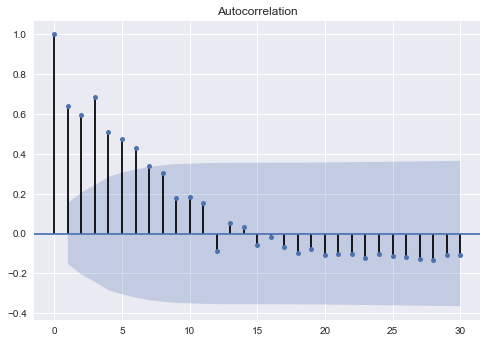

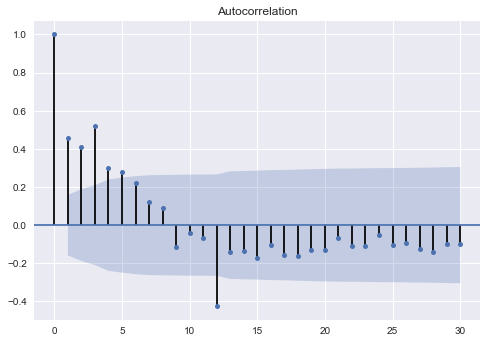

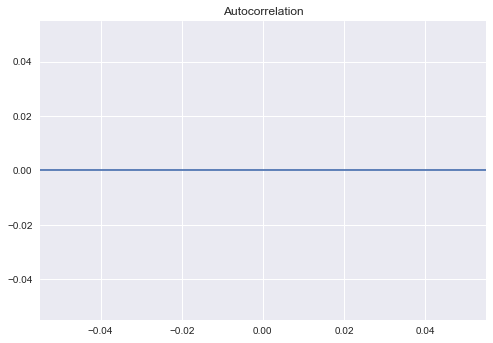

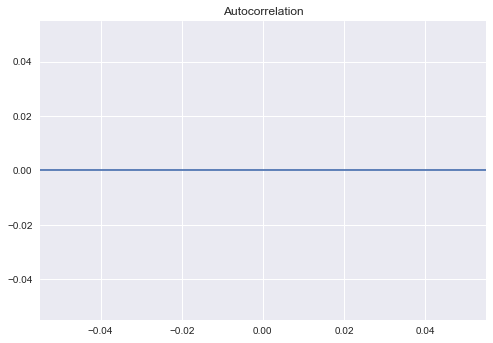

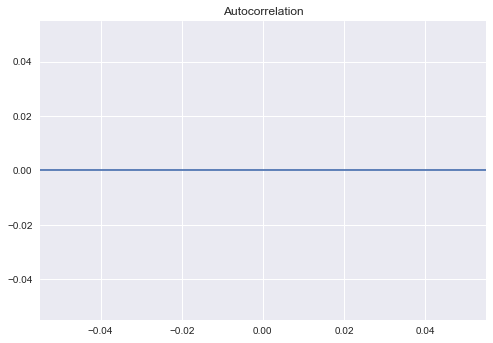

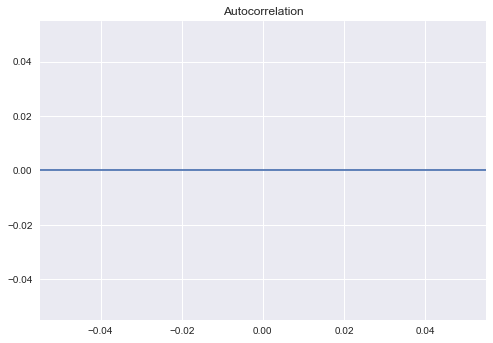

In [67]:
fig = sm.graphics.tsa.plot_acf(BART['RIDERS_DIFF'][12:], lags=30)
fig = sm.graphics.tsa.plot_acf(BART['RIDERS_DIFF_DIFF'][24:], lags=30)
fig = sm.graphics.tsa.plot_acf(BART['AVG_FARE_2010USD_BART'][12:], lags=30)
fig = sm.graphics.tsa.plot_acf(BART['FUEL_PRICE_2010USD'][12:], lags=30)
fig = sm.graphics.tsa.plot_acf(BART['TOLL_BB_PK_2010USD'][12:], lags=30)
fig = sm.graphics.tsa.plot_acf(BART['TOLL_BB_OP_2010USD'][12:], lags=30)

In [68]:
mod = smf.ols(formula='RIDERS_DIFF_DIFF ~ AVG_FARE_2010USD_BART + FUEL_PRICE_2010USD + TOLL_BB_PK_2010USD + TOLL_BB_OP_2010USD + CASUAL_CARPOOL + BART_STRIKE', data=BART)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       RIDERS_DIFF_DIFF   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     12.65
Date:                Mon, 10 Apr 2017   Prob (F-statistic):           2.26e-11
Time:                        17:46:11   Log-Likelihood:                -1681.3
No. Observations:                 147   AIC:                             3377.
Df Residuals:                     140   BIC:                             3398.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.809e+

In [69]:
#According to my model, average vare is not significant. 
#Therefore, it will be dropped out of the model to reduce model redundancy

In [70]:
mod = smf.ols(formula='RIDERS_DIFF_DIFF ~ FUEL_PRICE_2010USD + TOLL_BB_PK_2010USD + TOLL_BB_OP_2010USD + CASUAL_CARPOOL + BART_STRIKE', data=BART)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       RIDERS_DIFF_DIFF   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     14.92
Date:                Mon, 10 Apr 2017   Prob (F-statistic):           9.70e-12
Time:                        17:47:19   Log-Likelihood:                -1681.9
No. Observations:                 147   AIC:                             3376.
Df Residuals:                     141   BIC:                             3394.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.246e+05   1.22

In [71]:
#Same for Fuel Price

In [72]:
mod = smf.ols(formula='RIDERS_DIFF_DIFF ~ TOLL_BB_PK_2010USD + TOLL_BB_OP_2010USD + CASUAL_CARPOOL + BART_STRIKE', data=BART)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       RIDERS_DIFF_DIFF   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     17.86
Date:                Mon, 10 Apr 2017   Prob (F-statistic):           6.71e-12
Time:                        17:47:47   Log-Likelihood:                -1683.2
No. Observations:                 147   AIC:                             3376.
Df Residuals:                     142   BIC:                             3391.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.908e+05    1.2

Based on the latest regression model, we can see that all coefficients are significant.  However, there are some weird coefficients in the model.  For example, Peak Toll and Normal operating tool have the opposite effect on BART ridership.  This is strange because typically these should be correlated and that was what I was expecting.  The charts below show the plots for riders after transformation and each toll type:

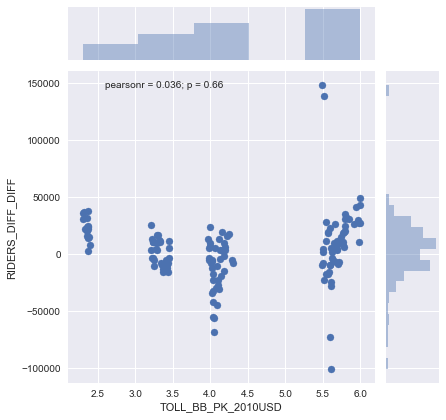

In [77]:
sns.jointplot(x="TOLL_BB_PK_2010USD", y="RIDERS_DIFF_DIFF", data=BART)

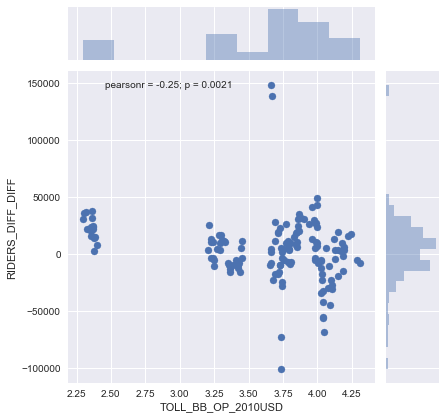

In [79]:
sns.jointplot(x="TOLL_BB_OP_2010USD", y="RIDERS_DIFF_DIFF", data=BART)

As can be seen from the above plots, when by itself, peak tolls do not have an appreciable effect on BART ridership by itself.  It is only when the variables above are held constant when an appreciable effect can be garnered.  Given BART ridership shouldn't increase when tolls increase, this variable cannot be explained and should be thrown out.

In [80]:
mod = smf.ols(formula='RIDERS_DIFF_DIFF ~ TOLL_BB_OP_2010USD + CASUAL_CARPOOL + BART_STRIKE', data=BART)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       RIDERS_DIFF_DIFF   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     21.50
Date:                Mon, 10 Apr 2017   Prob (F-statistic):           1.50e-11
Time:                        18:40:37   Log-Likelihood:                -1685.8
No. Observations:                 147   AIC:                             3380.
Df Residuals:                     143   BIC:                             3391.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           7.926e+04   1.44

The final code does make sense.  It states that for holding all the other variables constant, the variable in question is going to change with significance.  Also, the only continuous variable is tolls for operation and the categoricals are carpool a